In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Load total market volume
vol_all = pd.read_csv("crsp_daily_volume_all.csv", parse_dates=["date"])
vol_all = vol_all.rename(columns={"sh_volume": "volume_all"})
vol_all.set_index("date", inplace=True)

print(vol_all.head(10))
print(vol_all.info())


              volume_all
date                    
2000-01-03  2.693961e+09
2000-01-04  2.735845e+09
2000-01-05  3.057963e+09
2000-01-06  2.906864e+09
2000-01-07  3.118737e+09
2000-01-10  3.045530e+09
2000-01-11  2.946215e+09
2000-01-12  2.730199e+09
2000-01-13  2.711438e+09
2000-01-14  2.964148e+09
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6289 entries, 2000-01-03 to 2024-12-31
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   volume_all  6289 non-null   float64
dtypes: float64(1)
memory usage: 98.3 KB
None


In [3]:
# Load historical realized volatility
hist_vol = pd.read_csv( "daily_historical_volatility.csv", parse_dates=["date"])
hist_vol = hist_vol.rename(columns={"daily_vol": "hist_vol"})
hist_vol.set_index("date", inplace=True)

print(hist_vol.head(10))
print(hist_vol.info())


            hist_vol
date                
2000-01-03       NaN
2000-01-04       NaN
2000-01-05       NaN
2000-01-06       NaN
2000-01-07       NaN
2000-01-10       NaN
2000-01-11       NaN
2000-01-12       NaN
2000-01-13       NaN
2000-01-14       NaN
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6289 entries, 2000-01-03 to 2024-12-31
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   hist_vol  6269 non-null   float64
dtypes: float64(1)
memory usage: 98.3 KB
None


In [4]:
vix = pd.read_csv("vix_closing_prices_2004_to_today_FRED.csv", parse_dates=["date"])
vix = vix.rename(columns={"vix_close": "vix"})
vix.set_index("date", inplace=True)

print("VIX data loaded:")
print(vix.head(5))
print(vix.info())


VIX data loaded:
              vix
date             
2004-01-01    NaN
2004-01-02  18.22
2004-01-05  17.49
2004-01-06  16.73
2004-01-07  15.50
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5680 entries, 2004-01-01 to 2025-10-08
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   vix     5504 non-null   float64
dtypes: float64(1)
memory usage: 88.8 KB
None


In [5]:
# Merge all on date index using outer join to retain all dates
df = vol_all.join([hist_vol, vix], how="outer").sort_index()

print("Before trimming to VIX start date:")
print(df.info())


Before trimming to VIX start date:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6684 entries, 2000-01-03 to 2025-10-08
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   volume_all  6289 non-null   float64
 1   hist_vol    6269 non-null   float64
 2   vix         5504 non-null   float64
dtypes: float64(3)
memory usage: 208.9 KB
None


In [6]:
# Find first valid date of VIX data
vix_start = vix.index.min()
print("VIX starts on:", vix_start)

# Restrict merged dataset to that range
df = df.loc[vix_start:].copy()
print("After trimming to VIX start date:")
print(df.info())


VIX starts on: 2004-01-01 00:00:00
After trimming to VIX start date:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5680 entries, 2004-01-01 to 2025-10-08
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   volume_all  5285 non-null   float64
 1   hist_vol    5285 non-null   float64
 2   vix         5504 non-null   float64
dtypes: float64(3)
memory usage: 177.5 KB
None


In [7]:
### Handle missing values more smoothly ###
print("Missing values before interpolation:")
print(df.isna().sum())

# Linear interpolation between previous and next valid day
df = df.interpolate(method="linear", limit_direction="both")

# Drop any rows that might still be NaN after interpolation
df = df.dropna(subset=["volume_all", "hist_vol", "vix"])

print("\nMissing values after interpolation:")
print(df.isna().sum())



Missing values before interpolation:
volume_all    395
hist_vol      395
vix           176
dtype: int64

Missing values after interpolation:
volume_all    0
hist_vol      0
vix           0
dtype: int64


In [8]:
df["log_volume"] = np.log(df["volume_all"])
df["log_hist_vol"] = np.log(df["hist_vol"])
df["log_vix"] = np.log(df["vix"])

df.head(5)


,volume_all,hist_vol,vix,log_volume,log_hist_vol,log_vix
date,,,,,,
2004-01-01,3.213291e+09,9.601453,18.22,21.890562,2.261914,2.902520
2004-01-02,3.213291e+09,9.601453,18.22,21.890562,2.261914,2.902520
2004-01-05,4.529997e+09,10.124151,17.49,22.233987,2.314924,2.861629
2004-01-06,4.308225e+09,10.125366,16.73,22.183792,2.315044,2.817204
2004-01-07,4.697461e+09,9.542561,15.50,22.270288,2.255762,2.740840


In [9]:
# --- Save the merged dataset ---
out_path = "merged_volume_volatility.csv"
df.to_csv(out_path)
print(f"Cleaned dataset saved to: {out_path}")
print("Date range:", df.index.min(), "→", df.index.max())
print("Columns:", df.columns.tolist())

# --- Create train/test split ---
split_date = "2020-01-01"  # Change this date if needed

train = df.loc[:split_date].copy()
test = df.loc[split_date:].copy()

# --- Save the splits ---
train.to_csv("train_data.csv")
test.to_csv("test_data.csv")

print("\nTrain/test files saved:")
print(f"  • train_data.csv ({len(train)} rows, up to {train.index.max().date()})")
print(f"  • test_data.csv  ({len(test)} rows, from {test.index.min().date()})")



Cleaned dataset saved to: merged_volume_volatility.csv
Date range: 2004-01-01 00:00:00 → 2025-10-08 00:00:00
Columns: ['volume_all', 'hist_vol', 'vix', 'log_volume', 'log_hist_vol', 'log_vix']

Train/test files saved:
  • train_data.csv (4175 rows, up to 2020-01-01)
  • test_data.csv  (1506 rows, from 2020-01-01)


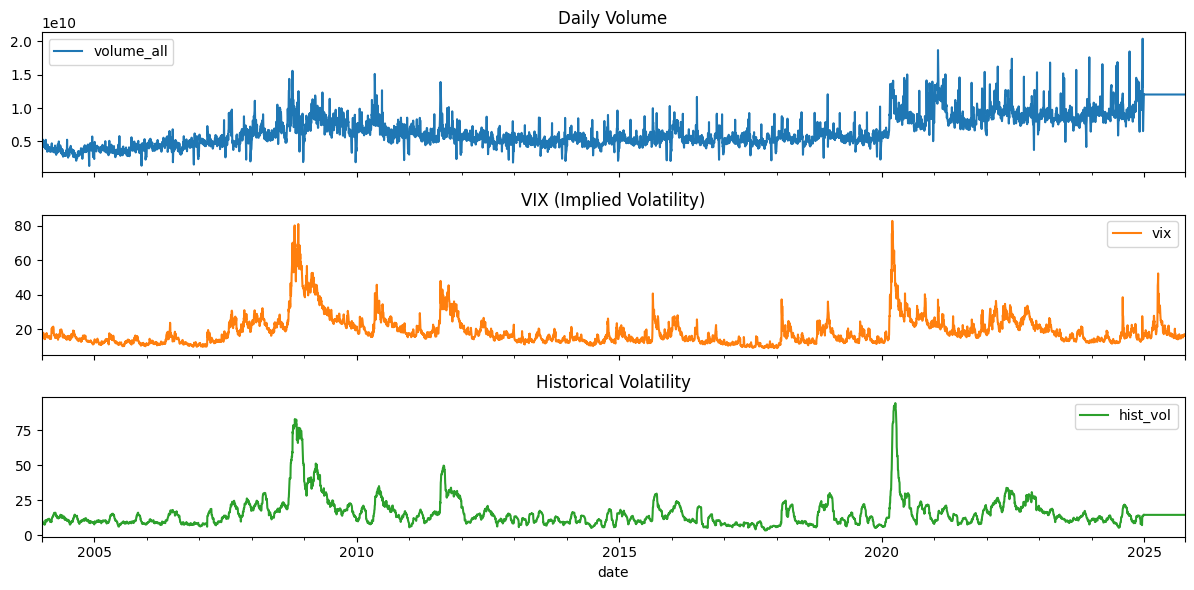

In [ ]:
df[["volume_all", "vix", "hist_vol"]].plot(
    subplots=True, figsize=(12,6),
    title=["Daily Volume", "VIX (Implied Volatility)", "Historical Volatility"]
)
plt.tight_layout()
plt.show()
